# Reference
[Random Forest Introduction](https://www.datascience.com/resources/notebooks/random-forest-intro)


In [33]:
# Import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from urllib.request import urlopen

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

## 1. Loading and Cleaning Dataset

In [34]:
# UCI_data_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases\
# /breast-cancer-wisconsin/wdbc.data'
# grabbed dataset manually outside and stored in datasets folder
UCI_data_URL = 'datasets/wdbc.data'


In [35]:
names = ['id_number', 'diagnosis', 'radius_mean',
         'texture_mean', 'perimeter_mean', 'area_mean',
         'smoothness_mean', 'compactness_mean',
         'concavity_mean','concave_points_mean',
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se',
         'area_se', 'smoothness_se', 'compactness_se',
         'concavity_se', 'concave_points_se',
         'symmetry_se', 'fractal_dimension_se',
         'radius_worst', 'texture_worst',
         'perimeter_worst', 'area_worst',
         'smoothness_worst', 'compactness_worst',
         'concavity_worst', 'concave_points_worst',
         'symmetry_worst', 'fractal_dimension_worst']

dx = ['Benign', 'Malignant']

In [36]:
breast_cancer = pd.read_csv(UCI_data_URL, names=names)

### Binarization

In [37]:
# Setting 'id_number' as our index
breast_cancer.set_index(['id_number'], inplace = True)
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M':1, 'B':0})

### Missing Values

In [38]:
for col in breast_cancer:
    if ((breast_cancer[col].isnull().values.ravel().sum()) == 0):
        pass
    else:
        print(col)
        print((breast_cancer[col].isnull().values.ravel().sum()))
print('Sanity Check! No missing Values found!')

Sanity Check! No missing Values found!


In [39]:
# For later use in CART models
names_index = names[2:]

# 2. Exploratory Data Analysis

In [40]:
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [41]:
print("Here's the dimensions of our data frame:\n",
     breast_cancer.shape)
print("Here's the data types of our columns:\n",
     breast_cancer.dtypes)

Here's the dimensions of our data frame:
 (569, 31)
Here's the data types of our columns:
 diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64

### Check Class Imbalance

In [42]:
def print_dx_perc(data_frame, col):
    """Function used to print class distribution for our data set"""
    dx_vals = data_frame[col].value_counts()
    dx_vals = dx_vals.reset_index()
    # Create a function to output the percentage
    f = lambda x, y: 100 * (x / sum(y))
    for i in range(0, len(dx)):
        print('{0} accounts for {1:.2f}% of the diagnosis class'\
          .format(dx[i], f(dx_vals[col].iloc[i],
                           dx_vals[col])))

In [43]:
print_dx_perc(breast_cancer, 'diagnosis')


Benign accounts for 62.74% of the diagnosis class
Malignant accounts for 37.26% of the diagnosis class


In [44]:
breast_cancer.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


# 3. Split Training and Test Set

In [45]:
feature_space = breast_cancer.iloc[:, breast_cancer.columns != 'diagnosis']
feature_class = breast_cancer.iloc[:, breast_cancer.columns == 'diagnosis']

training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20,
                                                                    random_state = 42)

In [46]:
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel()
test_class_set = test_class_set.values.ravel()

In [47]:
# Set the random state for reproductibility
fit_rf = RandomForestClassifier(random_state=42)

# 4. Find Best Model Parameters using GridSearch

In [48]:
np.random.seed(42)
start = time.time()

param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 10,
                     param_grid=param_dist,
                     n_jobs = 3)

cv_rf.fit(training_set, class_set)
print('Best Parameters using grid search: \n',
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2'}
Time taken in grid search:  3.78


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
# Set best parameters given by grid search
fit_rf.set_params(criterion = 'gini',
                  max_features = 'log2',
                  max_depth = 3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# 5. Find best forest size with model parameters from previous step

In [50]:
# Out-of-Bag Error Rate
fit_rf.set_params(warm_start=True,
                  oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(training_set, class_set)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

In [51]:
# Convert dictionary to a pandas series for easy plotting
oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

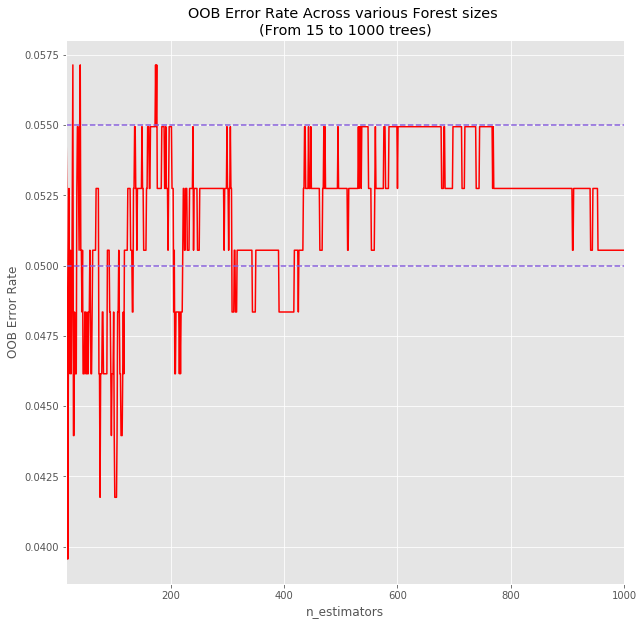

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))

# ax.set_axis_bgcolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.055,
            color='#875FDB',
           linestyle='--')
plt.axhline(0.05,
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

In [53]:
print('OOB Error rate for 400 trees is: {0:.5f}'.format(oob_series[400]))


OOB Error rate for 400 trees is: 0.04835


# 6. Train model with best parameters and best no of trees 

In [54]:
# Traditional Training and Test Set Split
fit_rf.set_params(n_estimators=400,
              bootstrap = True,
              warm_start=False,
              oob_score=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [55]:
fit_rf.fit(training_set, class_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# 7. Evaluate model
### What variables play important role in prediction?

In [56]:
# Variable Importance
importances_rf = fit_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

In [57]:
def variable_importance(importance, indices):
    """
    Purpose:
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on gini or information gain for CART model.

    Parameters:
    ----------
    names:      Name of columns included in model
    importance: Array returned from feature_importances_ for CART
                   models organized by dataframe index
    indices:    Organized index of dataframe from largest to smallest
                   based on feature_importances_

    Returns:
    ----------
    Print statement outputting variable importance in descending order
    """
    print("Feature ranking:")

    for f in range(len(names_index)):
        i = f
        print("%d. The feature '%s' \
has a Mean Decrease in Gini of %f" % (f + 1,
                                         names_index[indices[i]],
                                         importance[indices[f]]))

In [58]:
variable_importance(importances_rf, indices_rf)


Feature ranking:
1. The feature 'area_worst' has a Mean Decrease in Gini of 0.129856
2. The feature 'perimeter_worst' has a Mean Decrease in Gini of 0.120953
3. The feature 'concave_points_worst' has a Mean Decrease in Gini of 0.115548
4. The feature 'concave_points_mean' has a Mean Decrease in Gini of 0.100136
5. The feature 'radius_worst' has a Mean Decrease in Gini of 0.078047
6. The feature 'concavity_mean' has a Mean Decrease in Gini of 0.062143
7. The feature 'area_mean' has a Mean Decrease in Gini of 0.056556
8. The feature 'radius_mean' has a Mean Decrease in Gini of 0.054567
9. The feature 'perimeter_mean' has a Mean Decrease in Gini of 0.051745
10. The feature 'area_se' has a Mean Decrease in Gini of 0.043261
11. The feature 'concavity_worst' has a Mean Decrease in Gini of 0.038659
12. The feature 'compactness_worst' has a Mean Decrease in Gini of 0.020329
13. The feature 'compactness_mean' has a Mean Decrease in Gini of 0.016163
14. The feature 'texture_worst' has a Mean Dec

In [59]:
def variable_importance_plot(importance, indices):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    importance_desc: Array returned from feature_importances_ for CART
                    models organized in descending order

    indices: Organized index of dataframe from largest to smallest
                    based on feature_importances_
    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(29, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

#     ax.set_axis_bgcolor('#fafafa')
    plt.title('Feature importances for Random Forest Model\
    \nBreast Cancer (Diagnostic)')
    plt.barh(index,
         importance_desc,
         align="center",
         color = '#875FDB')
    plt.yticks(index,
           feature_space)

    plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc))
    plt.xlabel('Mean Decrease in Gini')
    plt.ylabel('Feature')

    plt.show()
    plt.close()


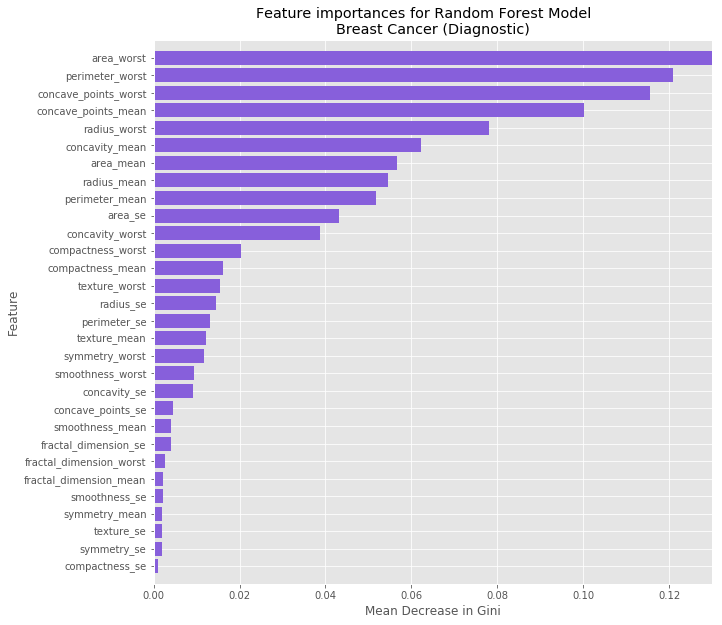

In [60]:
variable_importance_plot(importances_rf, indices_rf)


### Cross Validation

In [61]:
def cross_val_metrics(fit, training_set, class_set, print_results = True):
    """
    Purpose
    ----------
    Function helps automate cross validation processes while including
    option to print metrics or store in variable

    Parameters
    ----------
    fit: Fitted model
    training_set:  Data_frame containing 80% of original dataframe
    class_set:     data_frame containing the respective target vaues
                  for the training_set
    print_results: Boolean, if true prints the metrics, else saves metrics as
                  variables

    Returns
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
            from cross validation score's standard deviation)
    """
    n = KFold(n_splits=10)
    scores = cross_val_score(fit,
                     training_set,
                     class_set,
                     cv = n)
    if print_results:
        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})"\
          .format(scores.mean(), scores.std() / 2))
    else:
        return scores.mean(), scores.std() / 2

In [62]:
cross_val_metrics(fit_rf,
              training_set,
              class_set,
              print_results = True)

Accuracy:  0.947 (+/-  0.019)


In [63]:
predictions_rf = fit_rf.predict(test_set)

### Cross Tabulation

In [64]:
test_crosstb = pd.crosstab(index = test_class_set,
                           columns = predictions_rf)

# More human readable
test_crosstb = test_crosstb.rename(columns= {0: 'Benign', 1: 'Malignant'})
test_crosstb.index = ['Benign', 'Malignant']
test_crosstb.columns.name = 'n = 114'

In [65]:
test_crosstb

n = 114,Benign,Malignant
Benign,70,1
Malignant,3,40


### Model Accuracy

In [66]:
accuracy_rf = fit_rf.score(test_set, test_class_set)

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))

Here is our mean accuracy on the test set:
 0.965


### Error Rate

In [67]:
# Here we calculate the test error rate!
test_error_rate_rf = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

The test error rate for our model is:
  0.0351


### ROC Curve

In [68]:
fpr2, tpr2, _ = roc_curve(predictions_rf,
                      test_class_set)
predictions_prob = fit_rf.predict_proba(test_set)[:, 1]

In [69]:
auc_rf = auc(fpr2, tpr2)


In [70]:
def plot_roc_curve(fpr, tpr, auc, mod, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    fpr:  Array returned from sklearn.metrics.roc_curve for increasing
         false positive rates
    tpr:  Array returned from sklearn.metrics.roc_curve for increasing
         true positive rates
    auc:  Float returned from sklearn.metrics.auc (Area under Curve)
    mod:  String represenation of appropriate model, can only contain the
         following: ['knn', 'rf', 'nn']
    xlim: Set upper and lower x-limits
    ylim: Set upper and lower y-limits

    Returns:
    ----------
    Returns plot of Receiving Operating Curve for specific model. Allowing user to
    specify x and y-limits.
    """
    mod_list = ['knn', 'rf', 'nn']
    method = [('Kth Nearest Neighbor', 'deeppink'),
          ('Random Forest', 'red'),
          ('Neural Network', 'purple')]

    plot_title = ''
    color_value = ''
    for i in range(0, 3):
        if mod_list[i] == mod:
            plot_title = method[i][0]
            color_value = method[i][1]

    fig, ax = plt.subplots(figsize=(10, 10))
#     ax.set_axis_bgcolor('#fafafa')

    plt.plot(fpr, tpr,
         color=color_value,
         linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f}) \
          \nBreast Cancer Diagnostic'\
          .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()


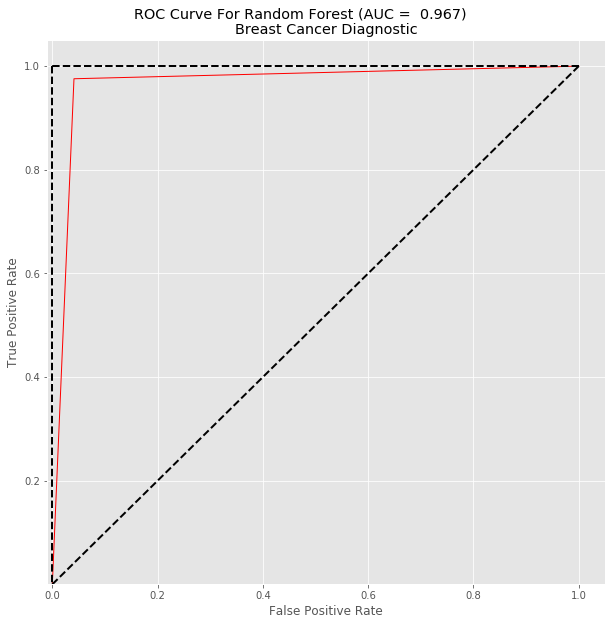

In [71]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
           xlim=(-0.01, 1.05),
           ylim=(0.001, 1.05))

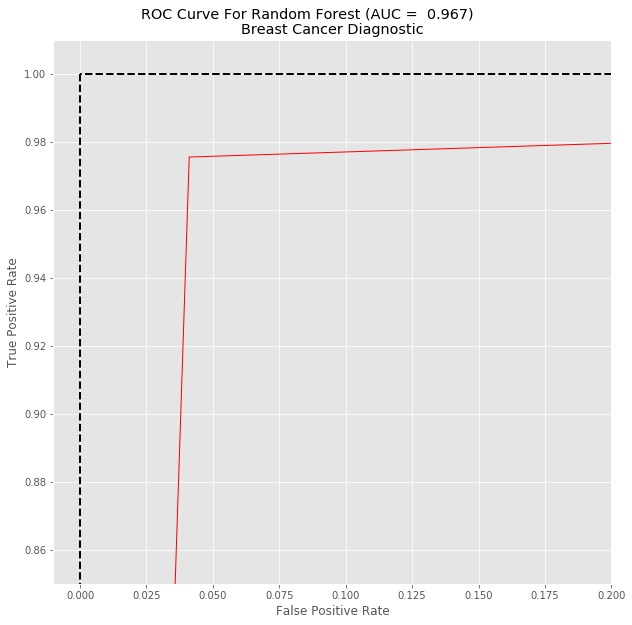

In [72]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 0.2),
               ylim=(0.85, 1.01))

### Classification Report (precision, recall, f1-score)

In [73]:
def print_class_report(predictions, alg_name): 
    """
    Purpose
    ----------
    Function helps automate the report generated by the sklearn package. Useful for multiple model comparison

    Parameters
    ----------
    Predictions:
    The predictions made by the algorithm used alg_name: String containing the name of the algorithm used

    Returns:
    ----------
    Returns classification report generated from sklearn.
    """
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(predictions,
            test_class_set,
            target_names = dx))

In [74]:
class_report = print_class_report(predictions_rf, 'Random Forest')


Classification Report for Random Forest:
              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97        73
   Malignant       0.93      0.98      0.95        41

   micro avg       0.96      0.96      0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

